# Notebook to compare different runs varying coupling constants
## Gather Plaquette, polyakov loop and Acceptance 
Author: Venkitesh Ayyar (vayyar@bu.edu) \
May 4, 2023

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv

In [4]:
# %matplotlib widget

In [5]:
%matplotlib notebook

### Gather observables

In [6]:
def f_get_plaquette(fname):
    
    
    # Get Plaquette values
    cmd="grep 'Plaq' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr=np.array([[int(i.split('[ ')[-1].split(' ]')[0]), 
      np.float64(i.split(' ')[-1]),
      np.float64(i.split(': ')[2].split(' s')[0])] 
     for i in op])
    
    return arr

def f_get_polyakov(fname):
    
    # Gather Polykov loop values
    cmd="grep 'Polyakov' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr=np.array([complex(np.float64(i.split(' ')[-1][1:-1].split(',')[0]),
             np.float64(i.split(' ')[-1][1:-1].split(',')[1])) 
     for i in op ])
    
    return arr


def f_get_traj_time(fname):
    
        ## Total time
    cmd="grep 'Total time for trajectory' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    arr=[np.float32(i.split(': ')[-1]) for i in op]
    
    return arr

def f_get_metropolis(fname,lgth):
    
        ## Metropolis values
    cmd="grep 'Metropolis_test' %s"%(fname)
#     print(cmd)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string
    # print(op[0])

    ## Other arrays have equilibriation data, metropolis doesn't. So we need to add nans to make them the same size
    
    arr_temp=[1 if (i.split(' ')[-1]=='ACCEPTED') else 0 for i in op] # Accept =1 , Reject = 0
    skip=lgth-len(arr_temp)
#     print("skip",skip)
    arr_skip=[np.nan for i in range(skip)]
    arr=np.array(arr_skip+arr_temp)
    
    return arr

In [7]:
def f_gather_data(fname):
    
#     full_size=210 ## Trick to avoid double runs
    
    arr1=f_get_plaquette(fname)
    
    arr2=f_get_polyakov(fname)
    
    arr3=f_get_traj_time(fname)
    
    lgth=min(len(arr1),len(arr2),len(arr3))
    print(lgth)

    arr4=f_get_metropolis(fname,lgth)
    
    ## Create dataframe
    cols=['iter','Plaquette','Polyakov','Traj_time','Accept','Plaq_epoch']
    df=pd.DataFrame(columns=cols)

    df['Plaquette']=arr1[:,1]
    df['Plaq_epoch']=arr1[:,2]
    df['iter']=arr1[:,0].astype(int)
    df['Polyakov']=arr2
    df['Traj_time']=arr3
    df['Accept']=arr4

    return df


def f_moments(y,L):
    ''' Compute susceptibility and Kurtosis for observables'''
    
    m=[gv.gvar(0,0) for i in range(5)]  # List to store moments
    m[0]=gv.gvar(1,1e-16) # zeroth moment is 1
    for i in range(1,5):
        m[i]=gv.dataset.avg_data(y**i)
    
    sus=(L**3)*(m[2]-(m[1]**2))

    if sus: # Don't measure if sus is 0
        kurt=(m[4] - 4* m[3] *m[1] + 6* m[2]* (m[1]**2) - 3* (m[1]**4))/(sus**2)
    else:
        kurt=gv.gvar(np.nan,np.nan)
        
    return sus,kurt

def f_get_summary(df,L):
    drop_idx=50

    y=df.Plaquette.values[drop_idx:]
    plaq=gv.dataset.avg_data(y)
    ## Susceptibility and Binder cumulant
    sus_plaq,kurt_plaq = f_moments(y,L)
    
    y=np.abs(df.Polyakov.values[drop_idx:])
    polyakov=gv.dataset.avg_data(y)
    ## Susceptibility and Binder cumulant
    sus_poly,kurt_poly = f_moments(y,L)

    y=df.Traj_time.values[drop_idx:]
    traj_time=gv.dataset.avg_data(y)
    
    y=df['Accept'].dropna().values
    Act=y[y==1].shape[0]
    Rjt=y[y==0].shape[0]
    accpt=Act* 100 /(Act+Rjt)

    return plaq, polyakov, sus_plaq, kurt_plaq, sus_poly, kurt_poly, accpt, traj_time



$$ \chi_\mathcal{O} = L^3 \left[ \langle \mathcal{O}^2 \rangle - {(\langle \mathcal{O} \rangle )}^2 \right] $$ 

$$ \kappa_\mathcal{O} = \frac{\langle \mathcal{O}^4 \rangle - 4 \langle \mathcal{O}^3 \rangle \langle \mathcal{O} \rangle +6 \langle \mathcal{O}^2 \rangle {\langle \mathcal{O} \rangle} ^2 - 3 {\langle \mathcal{O} \rangle}^4 }{\chi_\mathcal{O}^2}$$ 

In [8]:
L=16 
dict_list=[]

df_summary=pd.DataFrame([])

top_dir='/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/'

flist=[]
for fldr in glob.glob(top_dir+'run_L*'): 
    fname=fldr+'/HSDM.out'
    
    if not os.path.isfile(fname): continue
        
    flist.append(fname)
    
    
    try: 
        df=f_gather_data(fname)
        beta = float(fname.split('/')[-2].split('_')[-2].split('-')[-1])
        mf   = float(fname.split('/')[-2].split('_')[-1].split('-')[-1])
        dict1={'beta':beta, 'mf':mf, 'df':df}
    #     print(dict1)
    
        dict_list.append(dict1)
        # Get summary data
        plaq,polyakov,sus_plaq, kurt_plaq, sus_poly, kurt_poly,accpt,traj_time=f_get_summary(df,L)
        dict1={'beta':beta, 'mf':mf, 'plaq':plaq,'polyakov':polyakov,
               'chi_plaq':sus_plaq, 'B_plaq':kurt_plaq, 'chi_poly':sus_poly, 'B_poly':kurt_poly,
               'acceptance':accpt, 'traj_time':traj_time}

        df_summary=pd.concat([df_summary,pd.DataFrame(dict1,index=[df_summary.shape[0]+1])])    
    
    except Exception as e: 
        print(fname)
        print(e)
    

df_summary=df_summary.sort_values(by=['beta','mf']).reset_index(drop=True)

210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
210
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/run_Lx-16_Lt-6_beta-11.0_mf-0.6443/HSDM.out
Command 'grep 'Plaq' /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/run_Lx-16_Lt-6_beta-11.0_mf-0.6443/HSDM.out' returned non-zero exit status 1.
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/run_Lx-16_Lt-6_beta-12.0_mf-0.6443/HSDM.out
Command 'grep 'Plaq' /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/run_Lx-16_Lt-6_beta-12.0_mf-0.6443/HSDM.out' returned non-zero exit status 1.
/usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/run_Lx-16_Lt-6_beta-10.0_mf-0.6443/HSDM.out
Command 'grep 'Plaq' /usr/workspace/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_march14/dm_tests/runs/run_Lx-16_Lt-6_beta-10.0_mf-0.6443/HSDM.out' retu

In [9]:
# dict_list[0]['df']

In [10]:
df_summary

,beta,mf,plaq,polyakov,chi_plaq,B_plaq,chi_poly,B_poly,acceptance,traj_time
0,8.00,0.6443,0.289133(42),0.00327(13),0.001(140),2e-07 +- 14,0.0118(54),1.4(7.9)e-07,98.5,14.7178(26)
1,9.00,0.4443,0.342122(40),0.00336(14),0.001(157),2e-07 +- 27,0.0123(59),1.9(9.7)e-07,97.0,15.8416(29)
2,9.00,0.6443,0.341897(44),0.00350(14),0.001(174),2e-07 +- 20,0.0129(62),1.6(8.9)e-07,98.0,14.5209(13)
3,9.00,0.8443,0.341753(42),0.00336(14),0.001(166),2e-07 +- 22,0.0132(62),1.8(8.6)e-07,98.5,13.8744(15)
4,10.00,0.6443,0.420636(68),0.00362(15),0.003(332),1e-07 +- 9.8,0.0142(66),1.4(8.2)e-07,93.5,14.5536(21)
5,10.25,0.6443,0.46296(29),0.00344(13),0.06(1.57),4e-07 +- 0.17,0.0117(59),2(11)e-07,93.5,14.5738(15)
6,10.50,0.4443,0.537776(74),0.00404(17),0.004(460),2e-07 +- 16,0.0187(89),2.1(9.5)e-07,96.0,15.9867(19)
7,10.50,0.6443,0.534694(67),0.00382(16),0.003(413),1e-07 +- 21,0.0173(83),2.3(9.7)e-07,97.0,14.2149(26)
8,10.50,0.8443,0.531408(71),0.00402(16),0.003(436),2e-07 +- 18,0.0174(88),3(12)e-07,96.0,13.4915(14)
9,10.75,0.6443,0.560661(52),0.00845(42),0.002(338),2e-07 +- 52,0.118(53),2.9(8.0)e-07,98.0,14.2790(20)


## Summary plots

### Plot Polyakov loop vs $m_f$ for different $\beta$

In [11]:
mf_list   = np.sort(np.unique(df_summary.mf.values))
beta_list = np.sort(np.unique(df_summary.beta.values))

<IPython.core.display.Javascript object>


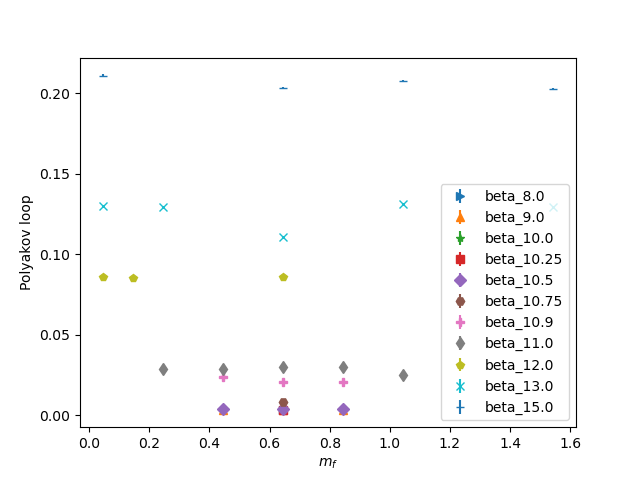

Text(0, 0.5, 'Polyakov loop')

In [12]:
plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.savefig('Ploop_vs_mf.pdf')

### Plot Polyakov loop vs $\beta$ for different $m_f$

<IPython.core.display.Javascript object>


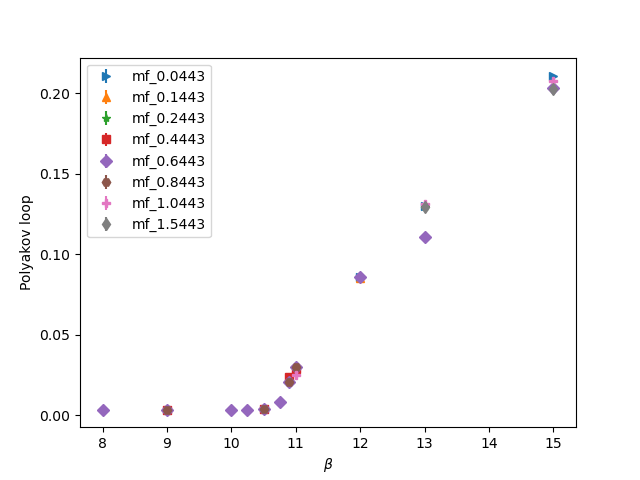

In [13]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.polyakov.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('Polyakov loop',rotation='vertical')
# plt.xlim(10.2,11.2)
# plt.ylim(0,0.04)
plt.savefig('Ploop_vs_beta.pdf')

### Plot Susceptibility

<IPython.core.display.Javascript object>


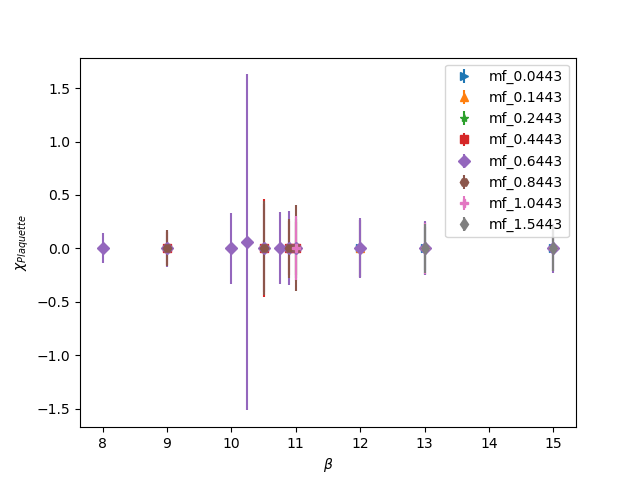

In [14]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.chi_plaq.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Plaquette}$',rotation='vertical')
plt.savefig('chi_plaq_vs_beta.pdf')

<IPython.core.display.Javascript object>


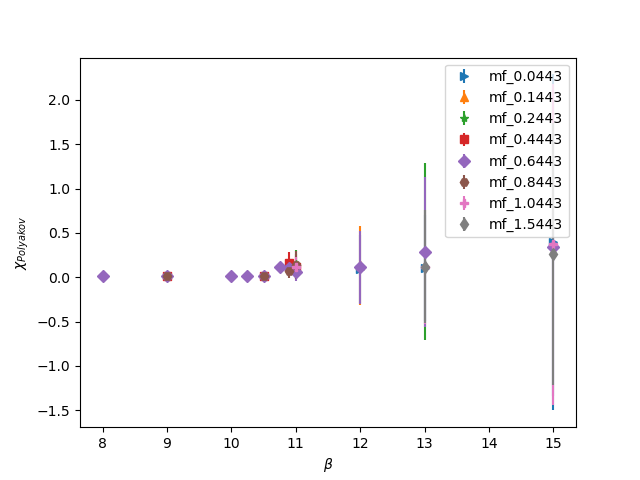

In [15]:
plt.figure()

for mf,marker in zip(mf_list,itertools.cycle('>^*sDHPdpx_')):
    label='mf_%s'%(mf)
    df1=df_summary[df_summary.mf==mf].sort_values(by=['beta'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.beta.values
    y=df1.chi_poly.values
#     print(x,y)
    plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.show()
plt.xlabel(r'$\beta$')
# plt.xticks(beta_list)
plt.legend()
plt.ylabel('$\chi_{Polyakov}$',rotation='vertical')
plt.savefig('chi_poly_vs_beta.pdf')

<IPython.core.display.Javascript object>


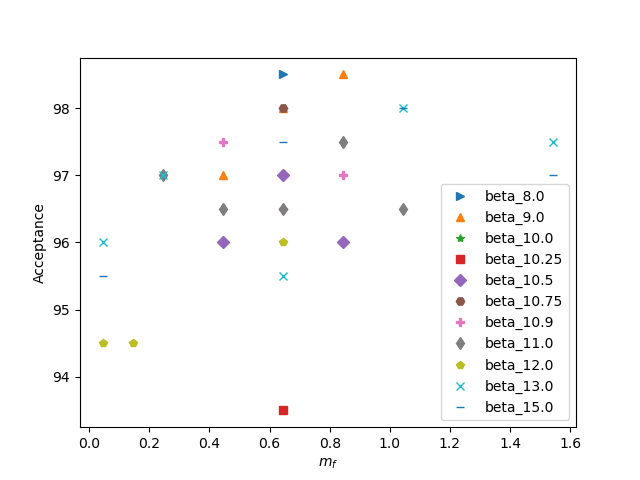

Text(0, 0.5, 'Acceptance')

In [16]:
# Plot acceptance rate 

plt.figure()

for beta,marker in zip(beta_list,itertools.cycle('>^*sDHPdpx_')):

    label='beta_%s'%(beta)
    df1=df_summary[df_summary.beta==beta].sort_values(by=['mf'])
#     display(df1)
    
#     if df1.shape[0]>1:
    x=df1.mf.values
    y=df1.acceptance.values
#     print(x,y)
    plt.plot(x,y,linestyle='',label=label,marker=marker)
#     plt.errorbar(x,gv.mean(y),gv.sdev(y),linestyle='',label=label,marker=marker)
        

plt.xlabel(r'$m_f$')
# plt.xticks(mf_list)
# plt.xlim(-0.5,2.0)
plt.legend(loc='best')
plt.ylabel('Acceptance',rotation='vertical')
# plt.savefig('Acceptance_vs_mf.pdf')

## Individual plots

<IPython.core.display.Javascript object>


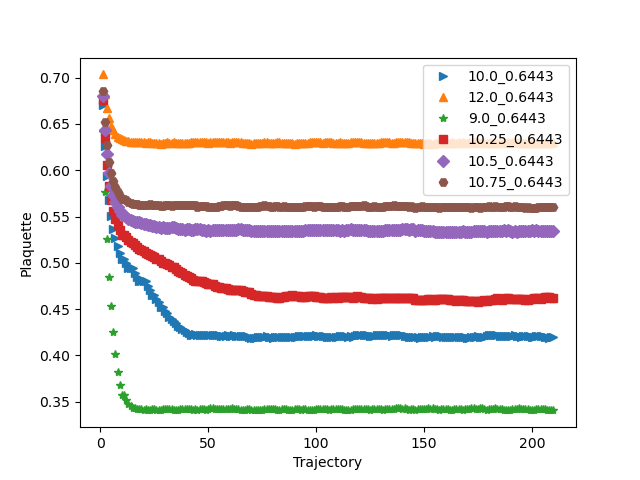

10.0_0.6443
12.0_0.6443
9.0_0.6443
10.25_0.6443
10.5_0.6443
10.75_0.6443


<IPython.core.display.Javascript object>


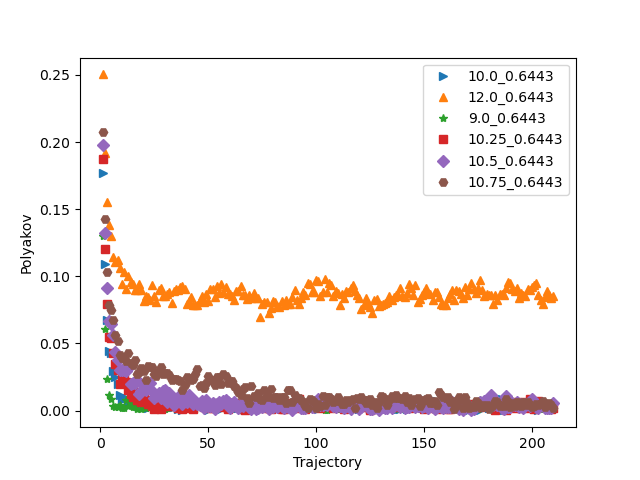

10.0_0.6443
12.0_0.6443
9.0_0.6443
10.25_0.6443
10.5_0.6443
10.75_0.6443


In [17]:

def f_plot_specific_runs(dict_list,column,beta_list,mf_list):
    ''' Plot behavior of quantity in MC time
    col = Plaquette, Polyakov, Traj_time, Accept, Plaq_epoch'''
    
    ## Gather list elements with given beta values
    short_list=[i for i in dict_list if i['beta'] in beta_list]
    ## Gather mf
    short_list=[i for i in short_list if i['mf'] in mf_list]
    
    assert len(short_list)>0 ,"Shortened list has 0 elements" 
    
    plt.figure()

    for i,marker in zip(short_list,itertools.cycle('>^*sDHPdpx_')):

        df=i['df']
        label=str(i['beta'])+'_'+str(i['mf'])
        print(label)
        x=df.iter.values
        if column=='Polyakov':
            y=np.abs(df[column].values)
        else:
            y=df[column].values

        plt.plot(x,y,linestyle='',label=label, marker=marker)

    plt.legend(loc='best')
    plt.ylabel(column)
    plt.xlabel('Trajectory')
    plt.show()
    
    
beta_list=[9.0,10.0,10.25, 10.5, 10.75,12.0]
# beta_list=[10.75,12.0]
mf_list=[0.6443]

# beta_list=[10.0,11.0,12.0]
# mf_list=[0.6443,0.8443]

f_plot_specific_runs(dict_list,'Plaquette',beta_list,mf_list)
plt.savefig('Plaq_details.pdf')

# f_plot_specific_runs(dict_list,'Traj_time',beta_list,mf_list)

f_plot_specific_runs(dict_list,'Polyakov',beta_list,mf_list)
plt.savefig('Polyakov_details.pdf')


<IPython.core.display.Javascript object>


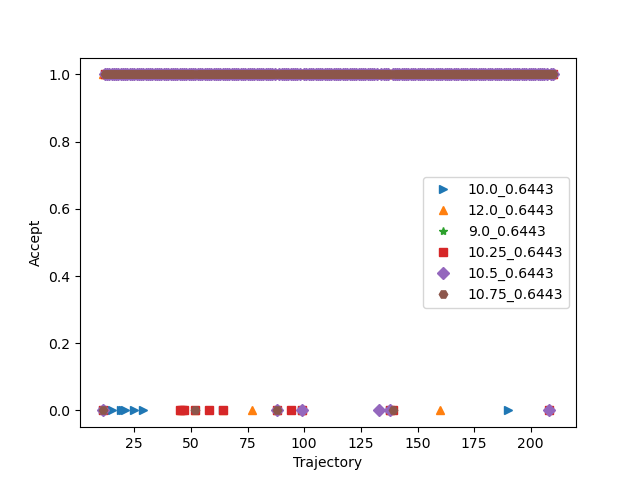

10.0_0.6443
12.0_0.6443
9.0_0.6443
10.25_0.6443
10.5_0.6443
10.75_0.6443


In [18]:
f_plot_specific_runs(dict_list,'Accept',beta_list,mf_list)


### Plot Polyakov loop

In [19]:
# fig=plt.figure()

# for i in dict_list:
#     df=i['df']
#     label=i['beta']+'_'+i['mf']
# #     print(label)
    
    
#     x=df.iter.values
#     y=df.Polyakov.values
#     fig.add_subplot(2,1,1)

#     plt.plot(x,y.real,marker='o',linestyle='',label=label)
#     plt.ylabel('Real Polyakov loop')

#     fig.add_subplot(2,1,2)

#     plt.plot(x,y.imag,marker='o',linestyle='',label=label)
    
# plt.legend(loc='best')
# plt.ylabel('Imag Polyakov loop')
# plt.show()


<IPython.core.display.Javascript object>


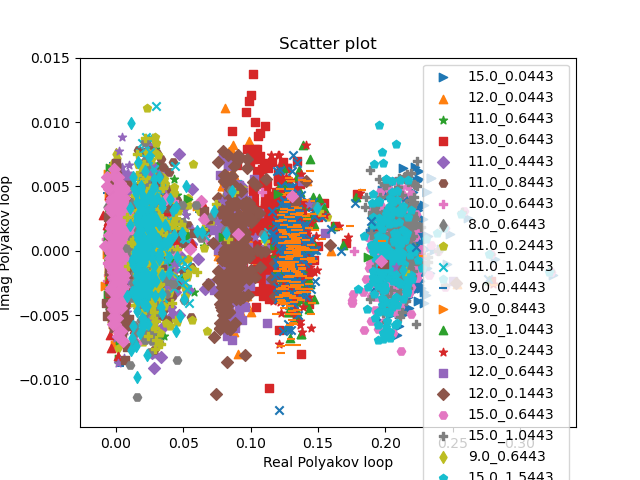

15.0_0.0443
12.0_0.0443
11.0_0.6443
13.0_0.6443
11.0_0.4443
11.0_0.8443
10.0_0.6443
8.0_0.6443
11.0_0.2443
11.0_1.0443
9.0_0.4443
9.0_0.8443
13.0_1.0443
13.0_0.2443
12.0_0.6443
12.0_0.1443
15.0_0.6443
15.0_1.0443
9.0_0.6443
15.0_1.5443
13.0_1.5443
13.0_0.0443
10.25_0.6443
10.5_0.6443
10.75_0.6443
10.5_0.4443
10.5_0.8443
10.9_0.8443
10.9_0.4443
10.9_0.6443


In [23]:
fig=plt.figure()

for i,marker in zip(dict_list,itertools.cycle('>^*sDHPdpx_')):
    df=i['df']
    label=str(i['beta'])+'_'+str(i['mf'])
    print(label)

    x=df.iter.values
    y=df.Polyakov.values

    y1=y.real
    y2=y.imag

    plt.scatter(y1,y2,label=label,marker=marker)
    
plt.legend(loc='best')
plt.xlabel('Real Polyakov loop')
plt.ylabel('Imag Polyakov loop')
plt.title("Scatter plot")
plt.show()

In [24]:
beta=10.5;mf=0.6443
dict_list

{'beta': 10.9,
 'mf': 0.6443,
 'df':      iter  Plaquette            Polyakov  Traj_time  Accept   Plaq_epoch
 0       1   0.687877  0.213330-0.001481j    13.9687     NaN    19.821183
 1       2   0.655855  0.149433+0.003318j    13.7712     NaN    33.609618
 2       3   0.633216  0.109824+0.001063j    13.7734     NaN    47.400114
 3       4   0.616028  0.086275+0.004660j    13.8062     NaN    61.223462
 4       5   0.604219  0.081958+0.001351j    13.8341     NaN    75.747250
 ..    ...        ...                 ...        ...     ...          ...
 205   206   0.572717  0.020365+0.000976j    13.9569     1.0  2889.934004
 206   207   0.572048  0.017700+0.001702j    13.9626     1.0  2903.913764
 207   208   0.571271  0.015224-0.009843j    13.9735     1.0  2917.904414
 208   209   0.571665  0.012665-0.005868j    13.9706     1.0  2931.892151
 209   210   0.571887  0.026647+0.002205j    13.9673     1.0  2945.876629
 
 [210 rows x 6 columns]}

<IPython.core.display.Javascript object>


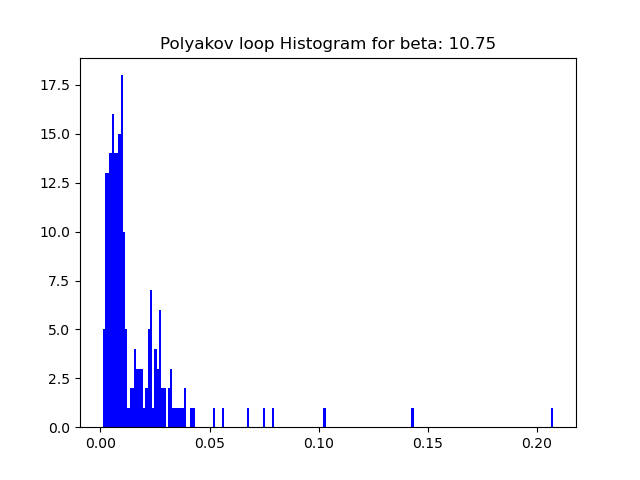

In [52]:
# Histogram
beta=10.75
mf=0.6443
df= [i for i in dict_list if ((i['beta']==beta) & (i['mf']==mf))][0]['df']

fig=plt.figure()
x=df.iter.values[:210]
y=np.abs(df.Polyakov.values[:210])

# hist,bins=np.histogram(y,bins=10)
# plt.bar(np.linspace(0,0.3,10),hist)
# plt.stairs(hist)

plt.hist(y,bins=200,color='b')

plt.title("Polyakov loop Histogram for beta: %s"%(beta))
plt.savefig('ploop_histogram.pdf')

In [22]:
df

,iter,Plaquette,Polyakov,Traj_time,Accept,Plaq_epoch
0,1,0.687877,0.213330-0.001481j,13.9687,NaN,19.821183
1,2,0.655855,0.149433+0.003318j,13.7712,NaN,33.609618
2,3,0.633216,0.109824+0.001063j,13.7734,NaN,47.400114
3,4,0.616028,0.086275+0.004660j,13.8062,NaN,61.223462
4,5,0.604219,0.081958+0.001351j,13.8341,NaN,75.747250
...,...,...,...,...,...,...
205,206,0.572717,0.020365+0.000976j,13.9569,1.0,2889.934004
206,207,0.572048,0.017700+0.001702j,13.9626,1.0,2903.913764
207,208,0.571271,0.015224-0.009843j,13.9735,1.0,2917.904414
208,209,0.571665,0.012665-0.005868j,13.9706,1.0,2931.892151


In [28]:
# df_summary
beta

15.0